## Pricing European Call Options

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit import QuantumCircuit
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit_aer.primitives import Sampler
from qiskit_finance.circuit.library import LogNormalDistribution

In [2]:
# Implement the uncertainity model


DAYS_IN_YEAR = 365
num_uncertainity_qubits = 3
spot_price = 2.0 # inital spot price
volatility = 0.4
annual_intrest_rate = 0.05
time_to_maturity = 40 / DAYS_IN_YEAR
mu = (annual_intrest_rate - 0.5 * volatility ** 2) * time_to_maturity + np.log(spot_price)
sigma = volatility * np.sqrt(time_to_maturity)
mean = np.exp(mu + sigma ** 2 / 2)
variance = (np.exp(sigma**2) - 1)* np.exp(2* mu + sigma ** 2)
stddev = np.sqrt(variance)

low = np.maximum(0, mean- 3 * stddev)
high = mean + 3 * stddev
uncertianity_model = LogNormalDistribution(num_qubits=num_uncertainity_qubits, mu=mu, sigma=sigma, bounds=(low, high))



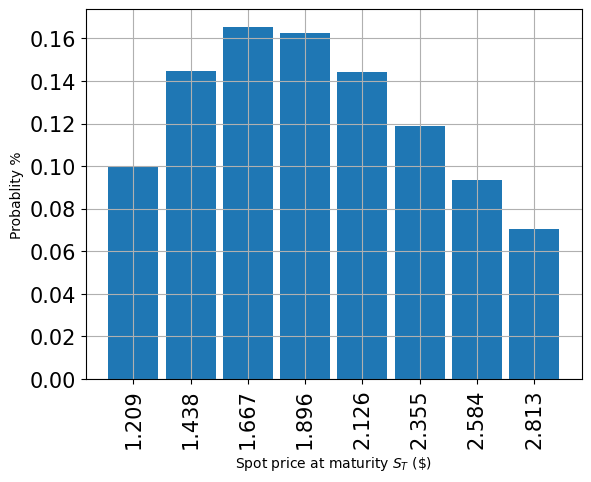

In [3]:
# Probablity distribution
x = uncertianity_model.values
y = uncertianity_model.probabilities
plt.bar(x,y,width=0.2)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Spot price at maturity $S_T$ (\$)")
plt.ylabel("Probablity %")
plt.show()


In [4]:
strike_price = 1.899 # Should be within high and low value of uncertainity
c_approx = 0.25 # Approximation scaling factor

break_point  = [low, strike_price]
slopes = [0,1]
offsets = [0,0]
fmin = 0
fmax = high - strike_price

european_call_objective = LinearAmplitudeFunction(
  num_state_qubits=num_uncertainity_qubits,
  slope=slopes,
  offset=offsets,
  domain=(low, high),
  image=(fmin, fmax),
  breakpoints=break_point,
  rescaling_factor=c_approx
)
num_qubits = european_call_objective.num_qubits
european_call = QuantumCircuit(num_qubits)
european_call.append(uncertianity_model, range(num_uncertainity_qubits))
european_call.append(european_call_objective, range(num_qubits))

european_call.draw()


┌───────┐┌────┐
q_0: ┤0      ├┤0   ├
     │       ││    │
q_1: ┤1 P(X) ├┤1   ├
     │       ││    │
q_2: ┤2      ├┤2   ├
     └───────┘│    │
q_3: ─────────┤3 F ├
              │    │
q_4: ─────────┤4   ├
              │    │
q_5: ─────────┤5   ├
              │    │
q_6: ─────────┤6   ├
              └────┘

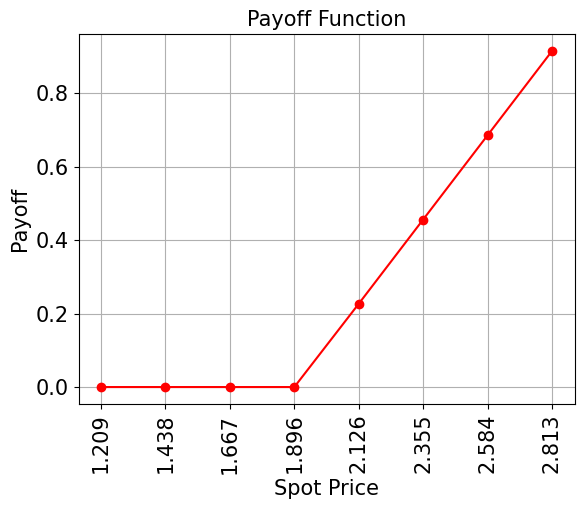

In [5]:
x = uncertianity_model.values
y = np.maximum(0, x - strike_price)
plt.plot(x,y,"ro-")
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel("Spot Price", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [6]:
exact_value = np.dot(uncertianity_model.probabilities, y)
exact_delta = sum(uncertianity_model.probabilities[x >= strike_price])
print("Exact Expected value:", str(exact_value))
print("Exact Delta value:", str(exact_delta))

Exact Expected value: 0.21552718347259392
Exact Delta value: 0.4272387162504412


In [10]:
precision = 0.01
confidence_level = 0.05

try:
  sampler = Sampler()#run_options={"seed": 75, "shots": 100})
  problem = EstimationProblem(state_preparation=european_call, objective_qubits=[3], post_processing=european_call_objective.post_processing)
  estimator = IterativeAmplitudeEstimation(epsilon_target=precision, alpha=confidence_level, sampler=sampler)
  result = estimator.estimate(problem)

  confidence_interval = np.array(result.confidence_interval_processed)
  print("Exact Value:", str(exact_value))
  print("Estimated Value:", str(result.estimation_processed))
  print(f"Confidence Interval: {confidence_interval} ")

except Exception as e:
  print(e)

: 

In [8]:
from qiskit_finance.applications.estimation import EuropeanCallPricing
precision = 0.01
confidence_level = 0.05
try:
  eu_pricing = EuropeanCallPricing(
    num_uncertainity_qubits,
    strike_price,
    c_approx,
    bounds=(low, high),
    uncertainty_model=uncertianity_model
  )
  problem = eu_pricing.to_estimation_problem()
  estimator = IterativeAmplitudeEstimation(precision, confidence_level, sampler=Sampler())
  result = estimator.estimate(problem)

  conf_int = np.array(result.confidence_interval_processed)
  print("Exact Value:", str(exact_value))
  print("Estimated Value:", str(eu_pricing.interpret(result)))
  print(f"Confidence Interval: {confidence_interval}")
except Exception as e:
  print(e)

: 

In [9]:
from qiskit_finance.applications.estimation import EuropeanCallDelta
epsilon = 0.01
alpha = 0.05
eu_call_delta = EuropeanCallDelta(
  num_uncertainity_qubits,
  strike_price,
  bounds=(low, high),
  uncertainty_model=uncertianity_model
)
eu_call_delta._objective.decompose().draw()


eu_call_delta_circ = QuantumCircuit(eu_call_delta._objective.num_qubits)
eu_call_delta_circ.append(uncertianity_model, range(num_uncertainity_qubits))
eu_call_delta_circ.append(eu_call_delta._objective, range(eu_call_delta._objective.num_qubits))
eu_call_delta_circ.draw()

problem = eu_call_delta.to_estimation_problem()
estimator = IterativeAmplitudeEstimation(epsilon, alpha, sampler=Sampler(run_options={"shots": 100, "seed": 75}))

result = estimator.estimate(problem)
conf_int = np.array(result.confidence_interval_processed)
print("Exact delta:", str(exact_delta))
print("Estimated value:", str(eu_call_delta.interpret(result)))
print(f"Confidence Interval: {confidence_interval}")


: 